In [1]:
%run workshop.py

# AI Fairness in Medicine: Integrated and Interactive Workshop

Let's take off our hats as medical staff and wear a new hat, AI developer, for a few hours. In the
end of this session, you will understand the basics of developing an AI solution for medical usage
through a simple example. You will also understand what is biases in AI development, their effects,
and a general idea on how to develop a fair AI solution.

There is no need to freak out even though you have zero experience in programming or even AI! This
material (which data scientists usually call it *notebook*) provides you a quick tutorial on the
machine learning lifecycle and does all the programming parts for you already.

## Part I: What does it mean to train an AI model?

There is no perfect answer in solving a problem using AI. There are many frameworks and methodology
that differ by the details, but the starting point is to understand what is the problem, what are
the data we have, and what is the goal to achieve using AI.

For example, in the context of medicine, an example problem could be to diagnose the patients given
a set of symptoms, to screen diseases or disorders given patient's imaging data, or to discover
new vaccine when the next pandemic arrives.

The diagram below depicts one viewpoint of the machine learning lifecycle. It explains briefly the
process of building an AI model to solve the predefined problem and to achieve the predefined goal.

<img src="https://towardsdatascience.com/wp-content/uploads/2024/11/1_dlG-Cju5ke-DKp8DQ9hiA@2x.jpeg"
alt="ml-lifecycle" width="400"/>

*Source: https://towardsdatascience.com/wp-content/uploads/2024/11/1_dlG-Cju5ke-DKp8DQ9hiA@2x.jpeg*

1. **Data Collection**

   We start by gathering relevant medical information like patient records, lab results, and imaging
   scans. AI developers must understand the problem well, especially in the medical context, and
   should find relevant data, or the resources, to build the AI solution efficiently.

2. **Data Cleaning**

   The raw data often contains errors, missing values, or inconsistencies that need fixing. We
   carefully review and correct these issues to ensure the information is accurate and reliable for
   analysis.

3. **Feature Engineering**

   This is when *inductive bias* first comes in. Here we identify and organize the most important
   pieces of medical data that do not exist originally in the data, but we complement them to help
   AI become more accurate. For example, we might calculate BMI from height and weight measurements,
   or track changes in lab values over time instead of given AI the raw values.

4. **Model Training**

    The AI model learns to capture patterns from between the collected data and the task"s goal
    after AI developers provide a set of constraints or rules. For example, capturing the hidden
    relationship between a protein and the docking site or recognizing the pattern between apneic
    episode and the SpO2 signal. This AI model can also be large language models (LLM) that we hear
    everyday in some specific tasks!

5. **Evaluation**

    After the model has learned from the data, we rigorously test its performance using metrics
    doctors understand, like sensitivity and specificity. We also check for biases to ensure that
    the patterns the model learned are fair and accurate across different patient groups before
    clinical use.

6. **Deployment**

    Once validated, we integrate the model into hospital systems where it can assist with tasks like
    flagging abnormal test results. This is done carefully with proper staff training and monitoring
    protocols.

7. **Monitoring**

    After launch, we continuously track the model"s performance in real-world use. Just like medical
    guidelines evolve, we update the models as we get new data or discover ways to improve them.

This ongoing cycle helps create AI tools that truly support clinical work while maintaining safety
and reliability. Your expertise remains essential for interpreting results and making final
decisions!

## Part II: Let's build your first medical AI model!

In this workshop, we will use a real-world medical dataset from the
[WiDS Datathon 2020](https://www.kaggle.com/competitions/widsdatathon2020/data), which contains
anonymized patient records from intensive care units (ICUs) around the world. The dataset includes a
wide range of clinical features such as demographics, vital signs, laboratory results, and
comorbidities collected during the first 24 hours of a patient's ICU stay.

While the original competition focused on predicting in-hospital mortality (`hospital_death`), our
goal will be to develop a model that predicts whether a patient has cirrhosis, using the `cirrhosis`
column as our target variable. This shift allows us to explore the challenges and considerations
involved in building AI models for different clinical outcomes, while practicing essential steps in
the machine learning workflow.

Let's first load the data and visualize it to understand it better.

In [2]:
df = get_dataframe("./data/training_v2.csv")

This is a sample of our data. We only see a few rows and a few columns.

In [3]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
19952,76989,88587,128,0,78.0,23.007286,0,Other/Unknown,F,157.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
38067,95916,76023,62,0,NaN,25.306173,0,Caucasian,M,177.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
72676,84972,60744,139,0,67.0,28.116078,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
56106,114200,41091,194,1,58.0,29.737515,0,Caucasian,F,157.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
71403,10126,107342,13,0,71.0,22.131519,0,Caucasian,F,157.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8134,71658,50982,168,0,72.0,14.844926,0,Caucasian,F,167.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
20545,14841,105000,55,0,71.0,33.201963,0,Caucasian,M,164.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
6227,20998,22269,118,0,67.0,25.377778,0,Hispanic,F,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
28865,64057,52757,79,0,51.0,20.484338,0,Native American,M,183.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


Plot below shows the distribution of each demographic traits including age and gender.

''

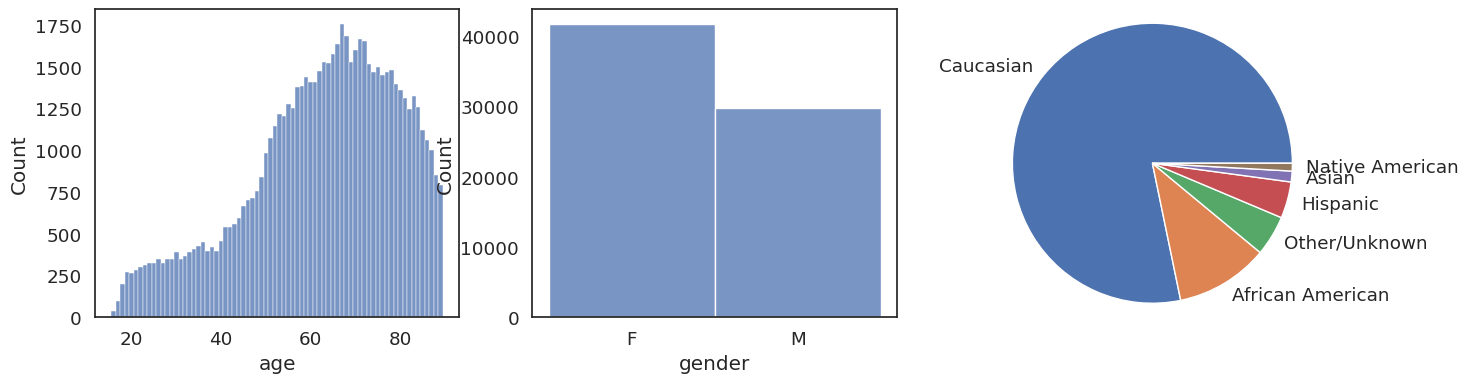

In [4]:
_, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(data=df, x="age", ax=axes[0], discrete=True)
sns.histplot(data=df, x="gender", ax=axes[1])

ethnicity_counts = df["ethnicity"].value_counts()
axes[2].pie(
    ethnicity_counts.values,
    labels=ethnicity_counts.index,
)
axes[2].axis("equal")
""

This dataset also contains the prevalence of 6 diseases: leukemia, hepatic failure,
immunosuppression, lymphoma, cirrhosis, and aids. Let's take a quick look on how each disease
prevalence distributes across gender and ethnicity.

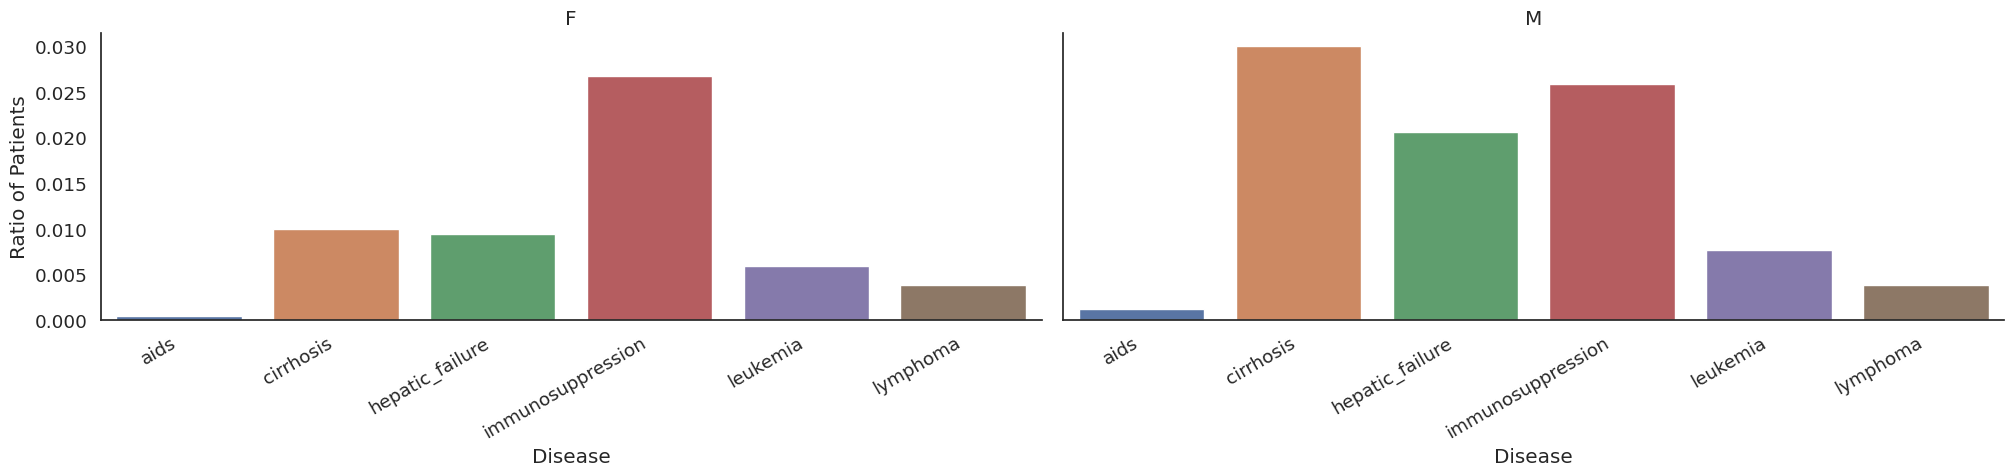

In [5]:
bar_chart_of_diseases(df, group_by="gender")

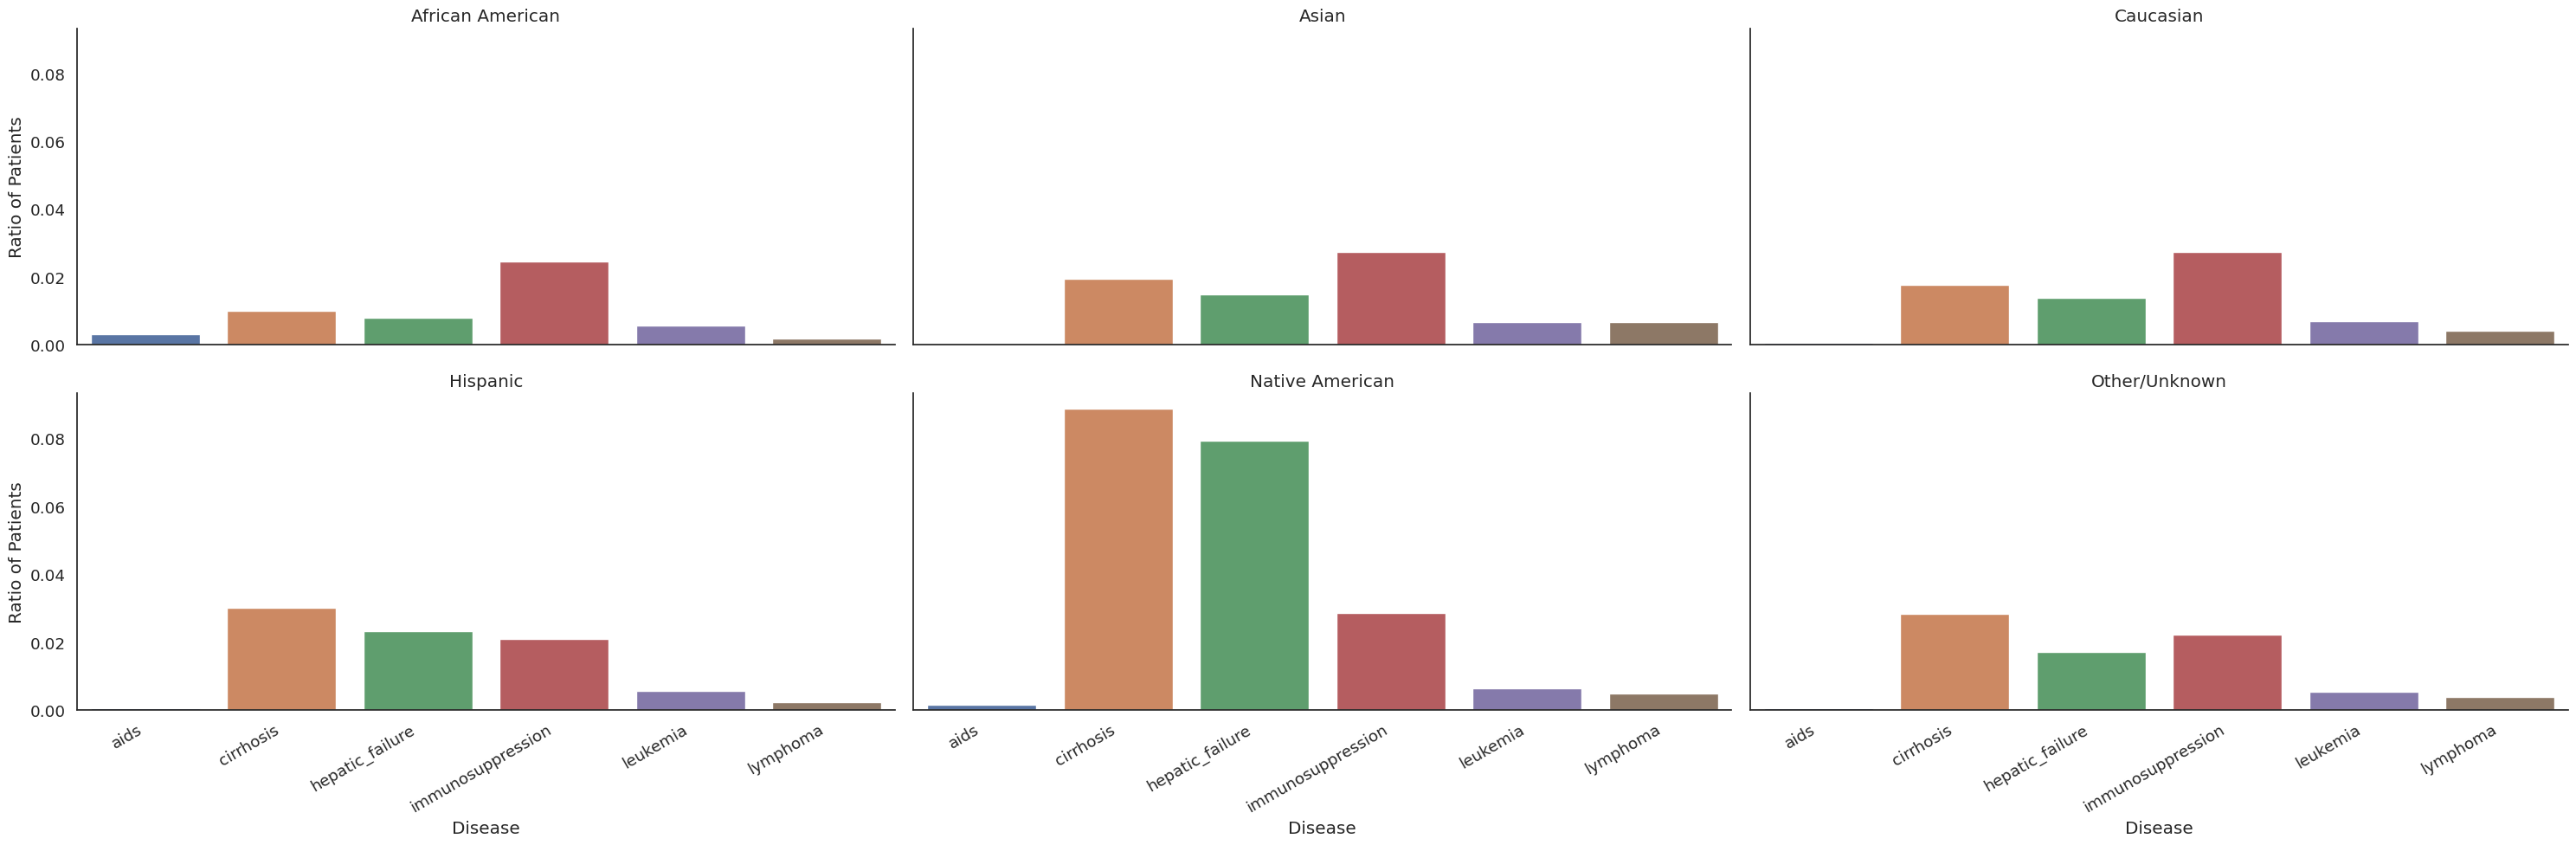

In [6]:
bar_chart_of_diseases(df, group_by="ethnicity")

**🔍 Findings**

- **Mean age is 62**, left skewed. Younger people are underrepresented.
- **Men is underrepresented. Diseases are more common in men**.
  The difference is significant in cirrhosis, hepatic failure, aids, and leukemia. Let's discuss why might be the reasons.
- **77% of patients are white**.

There are also other data attributes that we can extract from the data. These attributes are what
we usually call them *features* in the context of machine learning. 

The followings are some of the data we had gathered. For each of the name, we record the maximum and minimum values during the first hour and the first day of the visit. In addition, we have demographic details such that age, gender, ethnicity, weight, height, and so on.

In [7]:
display_feature_columns(df)

diasbp_invasive       diasbp                diasbp_noninvasive    heartrate            
mbp_invasive          mbp                   mbp_noninvasive       resprate             
spo2                  sysbp_invasive        sysbp                 sysbp_noninvasive    
temp                  albumin               bilirubin             bun                  
calcium               creatinine            glucose               hco3                 
hemaglobin            hematocrit            inr                   lactate              
platelets             potassium             sodium                wbc                  
arterial_pco2         arterial_ph           arterial_po2          pao2fio2ratio        


We use the convention that prefixes `d1` and `h1` represent the record of the first day and the first hour respectively, and the suffixes `max` and `min` represent the maximal and the minimal value recorded during that period.

## Modeling

For now, let's focus on only one bias we found in the dataset, that is, cirrhosis is more common in men than in women. The following plot shows that the ratio of male patient is around 3 times that of female.

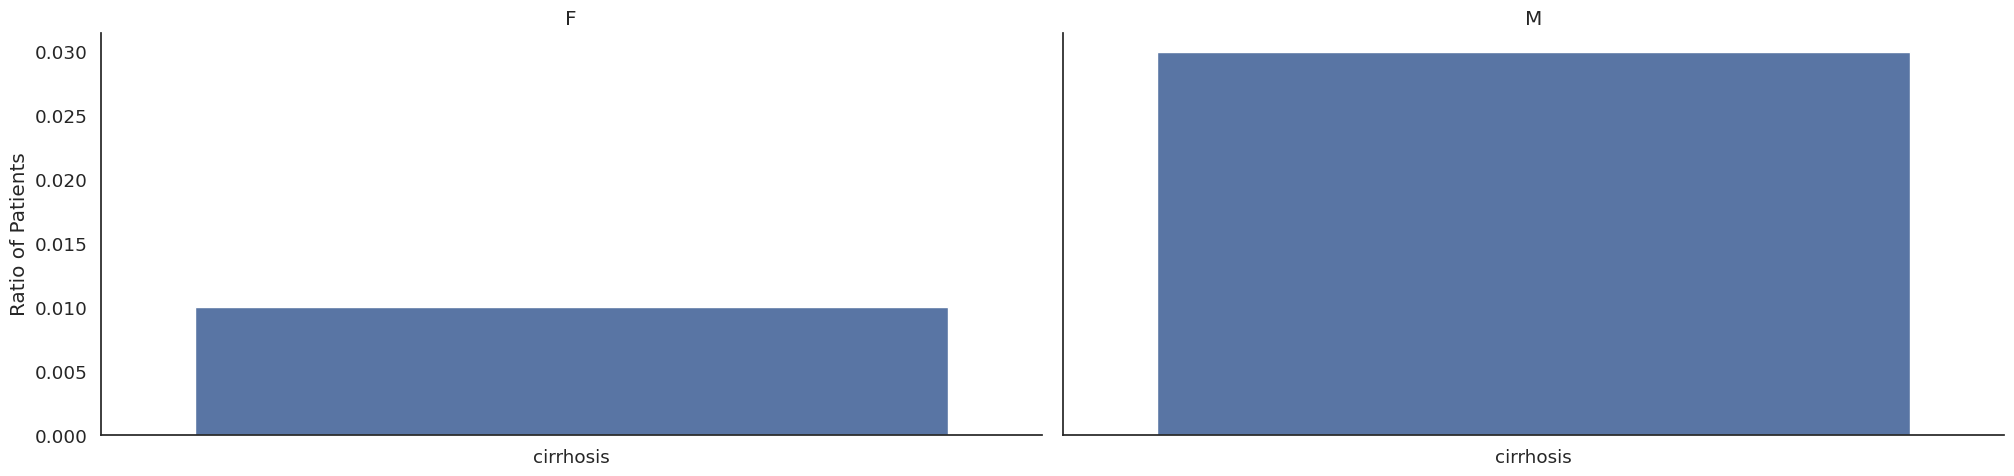

In [8]:
bar_chart_of_cirrhosis(df, group_by="gender")

We selected these features for a basic model, but feel free to add or remove ones you think are irrelevant!

In [9]:
BASIC_FEATURES = [
    "d1_albumin_max", "d1_albumin_min",
    "d1_inr_max","d1_inr_min",
    "d1_bilirubin_max", "d1_bilirubin_min",
    "d1_platelets_min", 
    "d1_mbp_min",
    "d1_creatinine_max",
    "d1_sodium_min", 
    "d1_potassium_max",
    "d1_temp_max", "d1_temp_min",
    "d1_wbc_max", "d1_wbc_min",
    "d1_lactate_max"
]

To keep things simple, we have written a function to train and evaluate the model given the dataset and features to be used. The model is a random forest classifier. If you want to see the full implementation, headover to the python `workshop.py` file.

Now let's practice what we have discussed. From the list below, choose **two** or **three** problems
that you are familiar with then proceed.

Given a problem and a goal, which types of patient data should we collect? And how would it help
constructing an accurate model? What are the other use cases in ICU care or medical practice that we
can apply this solution to? Do they have the same format of data? Can we apply the same data
cleaning method? If you cannot think of any, what about applying the same modeling technique to the
following problems?

1. Estimating ST-elevation from ECG signal
2. Detecting lung cancer from CXR images
3. Adjusting insulin dose from CGM data
4. Sepsis prediction in the ICU
5. Early warning system (EWS) for deterioration
6. Data extraction from clinician notes for flowsheets
7. Bed management

Discuss your thoughts with your group!

## Part III: Monitoring your AI model

A confusion matrix is a fundamental tool for evaluating the performance of a classification model.
It is a table that summarizes the number of correct and incorrect predictions made by the model,
broken down by each class. The matrix displays counts of true positives (TP), true negatives (TN),
false positives (FP), and false negatives (FN), allowing us to see not only the overall accuracy but
also the types of errors the model is making. This detailed breakdown helps identify whether the
model is biased toward certain classes or is systematically making specific types of mistakes.

<img src="https://www.researchgate.net/publication/377027146/figure/fig5/AS:11431281215285308@1704113587226/The-Matrix-of-TP-FP-FN-TN-Precision-Recall-dan-Accuracy.ppm"
alt="cm-definition" width="400"/>

Beyond the confusion matrix, other important evaluation metrics include precision, recall
(sensitivity), specificity, F1-score, and the area under the receiver operating characteristic curve
(AUC-ROC).

- **Precision** measures the proportion of positive predictions that are actually correct.
- **Recall** measures the proportion of actual positives that are correctly identified.
- The **F1-score** provides a balance between precision and recall, especially useful in imbalanced
  datasets.
- **AUC-ROC** evaluates the models ability to distinguish between classes across different thresholds.

These metrics provide a more comprehensive understanding of model performance, especially in medical
or high-stakes applications where certain types of errors may have greater consequences.


Before continuing, based on the problems you selected earlier, what should be the evaluation metrics for those problems?

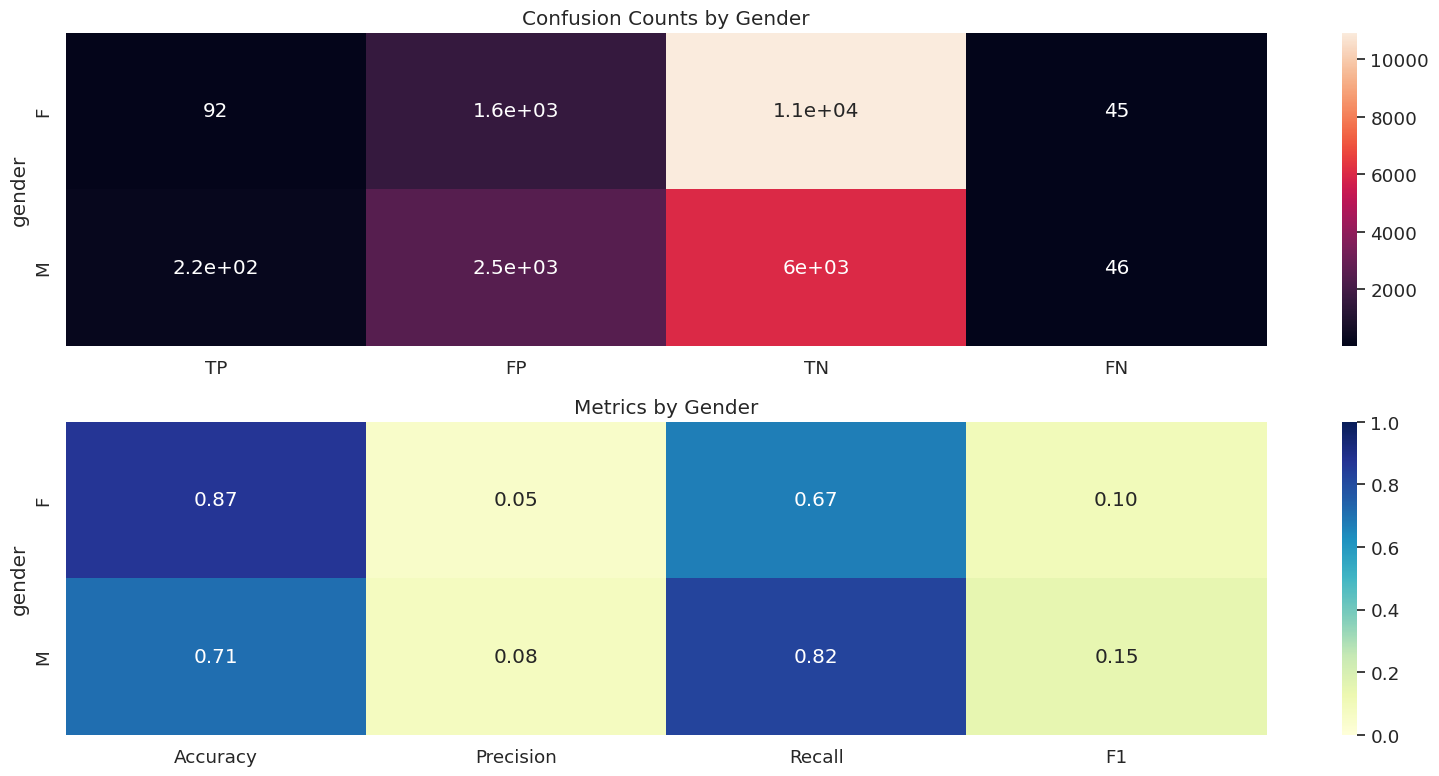

In [10]:
result_df = train_and_evaluate(df=df,
                               numerical_features=BASIC_FEATURES,
                               categorical_features=["gender"],
                               target="cirrhosis",
                              )
plot_model_result(result_df)

The accuracy and the Recall is quite high. Is that what we want? Is that all we want?

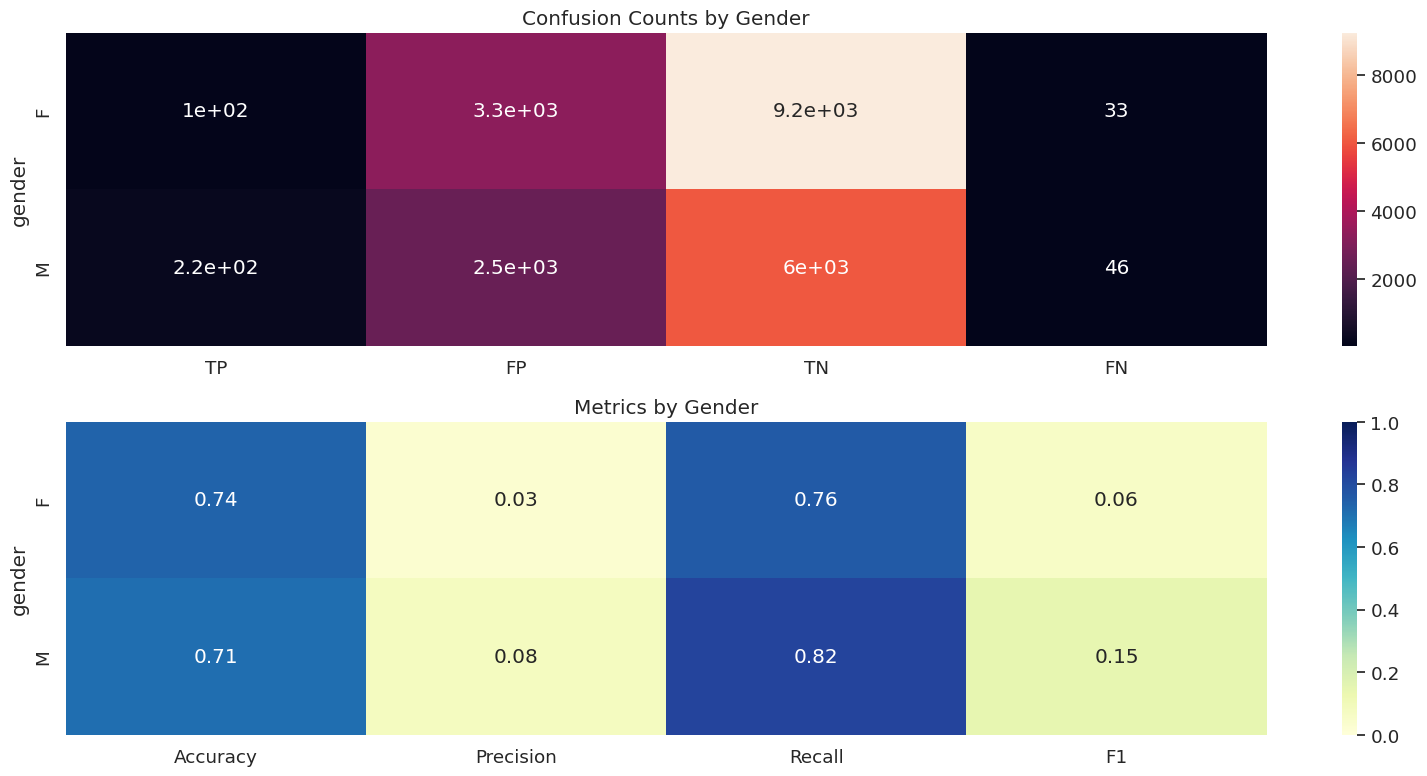

In [11]:
result_df = train_and_evaluate(df=df,
                               numerical_features=BASIC_FEATURES,
                               categorical_features=["gender"],
                               target="cirrhosis",
                               everyone_as_male=True
                               )
plot_model_result(result_df)

Nope, if we mistakenly say that a female patient is male, then the prediction changes drastically although there is no biological reason to expect so. 

You can see the difference between the last two figures. The first one is a normal one and the second one is the one where we say everyone are male. We have a lot more True Positive female patients!

Now, before we look into how we can mitigate the gender bias, could you see how does this bias occur?

In [12]:
def mitigate_gender_bias (X_train, y_train): 
    df_temp = Xy_combine(X_train, y_train)
    df_temp = make_gender_balance(df_temp, 0.5, 0.5)
    y_train = df_temp.cirrhosis.copy()
    X_train = df_temp.drop(columns=["cirrhosis"])
    return X_train, y_train

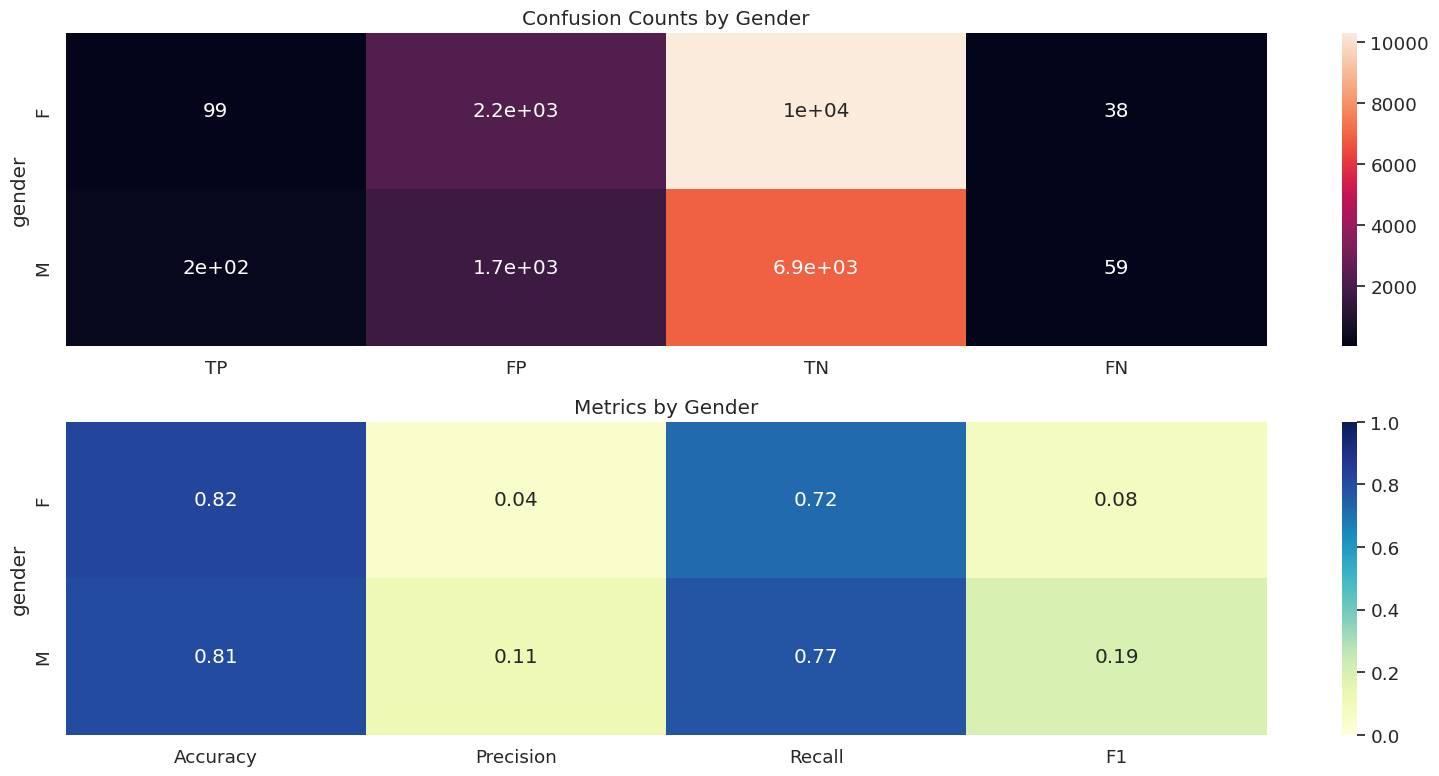

In [13]:
result_df = train_and_evaluate(df=df,
                               numerical_features=BASIC_FEATURES,
                               categorical_features=["gender"],
                               target="cirrhosis",
                               mitigate_bias=mitigate_gender_bias,
                               )
plot_model_result(result_df)

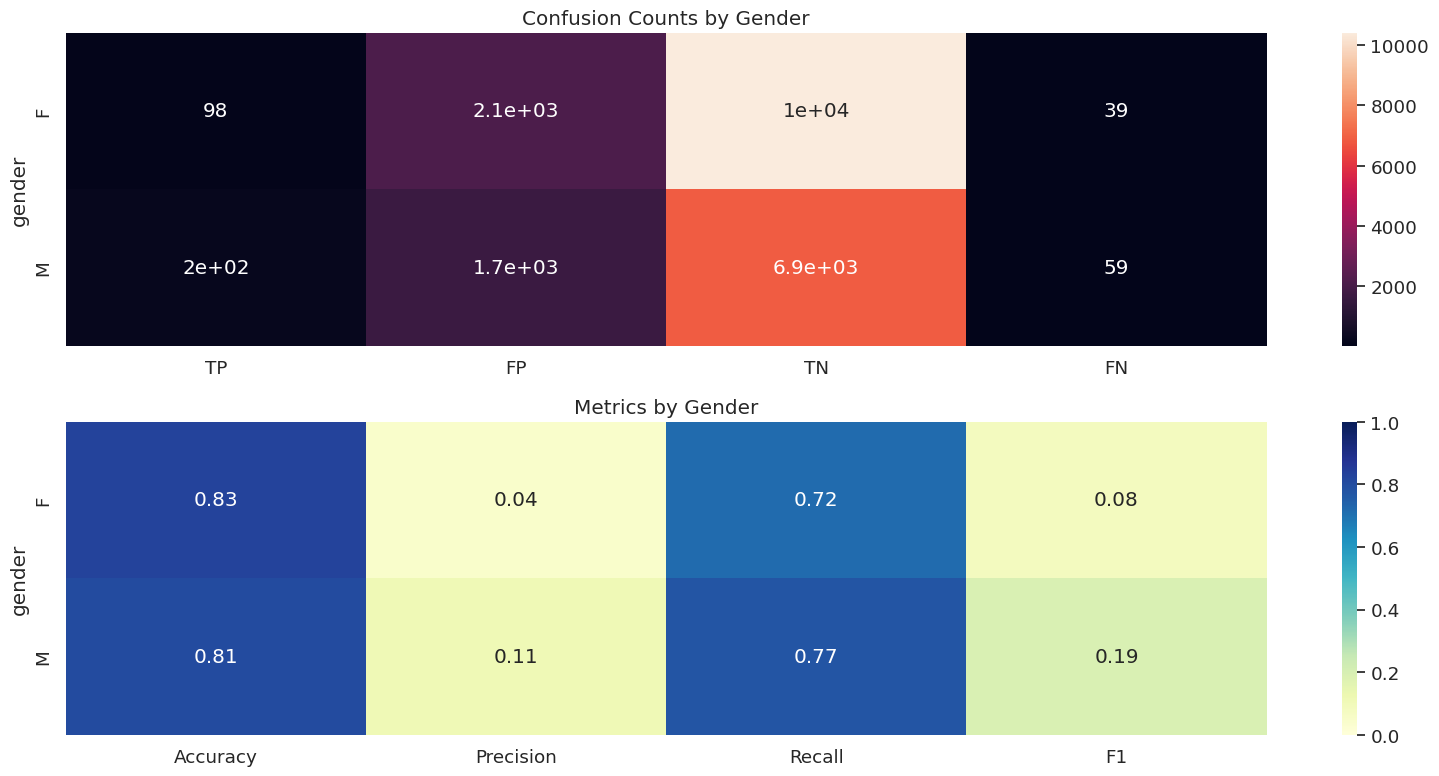

In [14]:
result_df = train_and_evaluate(df=df,
                               numerical_features=BASIC_FEATURES,
                               categorical_features=["gender"],
                               target="cirrhosis",
                               mitigate_bias=mitigate_gender_bias,
                               everyone_as_male=True
                               )
plot_model_result(result_df)

Now, misrepresenting the gender does not affect much!

Imbalaced datasets pose a significant challenge in medical AI because the model may learn to favor the majority class, leading to poor detection of rate but critical conditions. In this case, the ratio of male patients is three time that of female. This means that the model try to favor the majority by saying that men have cirrhosis and women don't. 

We addressed this issue by resampling the dataset as we know for a fact that biologically, men and women has similar risk for cirrhosis, therefore. We resample the dataset so that the new dataset has the same ratio of male and female patient, the model then performed better.

At the end, let us take a step further and discuss these issues: 
- Can you think of any example that bias would help training a more accurate model, or when are biases useful?
- Stick to that example, how do you know that the bias is fair or unfair, good or bad.
- How can we prevent the bias into machine learning life cycle?
- How do we know if ChatGPT is safe from bias? What questions should we ask in order to know the answer?
- How should we use ChatGPT, knowing that it has bias?